In [1]:
import pandas
import numpy
import datetime
import sklearn
import matplotlib.pyplot as pyplot

In [2]:
df = pandas.read_csv('openpv_all.csv',engine='python')


In [3]:
df['date'] = pandas.to_datetime(df['date_installed']).apply(lambda dt: dt.replace(day=15))

In [4]:
df['year'] = df['date_installed'].str.slice(-4).astype(float)
df['count'] = 1.
df['rebates']=df['rebate'].str.strip('$-').str.replace(',','').astype(float)
df['pct_reported_prod'] = 100*df.reported_annual_energy_prod/df.annual_PV_prod
df['install_type'] = df['install_type'].str.lower().str.split().str[0]
df['state'] = df['state'].str.strip()

In [5]:
#df.loc[283482]
#stateinsol['StateID'].value_counts()

In [6]:
stateinsol = pandas.read_csv('stateinsolations.csv')
stateinsol.head()

def NewInsol(x):
    if numpy.isnan(x['annual_insolation']):
        temp_ = stateinsol[(stateinsol['StateID'] == x['state'])]['Insolation']
        return temp_.item()
         
    else:
        return x['annual_insolation']
df['new_insolation'] = df[['annual_insolation','state']].apply(NewInsol,axis=1)

In [35]:
print stateinsol.head()

  StateID  Insolation
0      AL        5.12
1      AK         NaN
2      AZ        6.58
3      AR        5.01
4      CA        6.08


In [7]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


raw = DataFrame()
raw['ob1'] = [x for x in range(10)]
raw['ob2'] = [x for x in range(50, 60)]
values = raw.values
data = series_to_supervised(values, 5, 1)


In [8]:
raw = DataFrame()
this_state = df['state'].value_counts().index[0]
print this_state
raw['cost']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['cost']
raw['rebates']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['rebates']
raw['size_kw']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['size_kw']
raw['new_insolation']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['new_insolation']
#raw['cost_per_watt']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['cost_per_watt']
raw['cost_per_watt'] = raw['cost']/raw['size_kw']*1000.
values = raw.values
pastnum = 3
data = series_to_supervised(values,pastnum,1)
#data['cost_per_watt']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['cost_per_watt']
#data['new_insolation']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['new_insolation']

print data.shape[0]
mindat = pastnum+1
maxdat = data.shape[0]


CA
189


In [9]:
from sklearn.metrics import mean_squared_log_error
def rmsle(ytrue, ypred):
    return numpy.sqrt(mean_squared_log_error(ytrue, ypred))

In [10]:
mean_error = []
for year in range(mindat+1,maxdat,5):
    train = data[data.index < year]
    val = data[data.index == year]
    
    p = val['var1(t-1)'].values
    
    error = rmsle(val['var1(t)'].values, p)
    print('year %d - Error %.5f' % (year, error))
    mean_error.append(error)
print('Mean Error = %.5f' % numpy.mean(mean_error))

year 5 - Error 0.42122
year 10 - Error 0.16280
year 15 - Error 0.40340
year 20 - Error 0.36385
year 25 - Error 0.16293
year 30 - Error 0.07199
year 35 - Error 0.47475
year 40 - Error 0.48170
year 45 - Error 0.22927
year 50 - Error 0.58501
year 55 - Error 0.25308
year 60 - Error 0.33783
year 65 - Error 0.33180
year 70 - Error 0.45277
year 75 - Error 0.00740
year 80 - Error 0.30347
year 85 - Error 0.14935
year 90 - Error 0.05960
year 95 - Error 0.06280
year 100 - Error 0.56974
year 105 - Error 0.29327
year 110 - Error 0.51224
year 115 - Error 0.19052
year 120 - Error 0.15946
year 125 - Error 0.37543
year 130 - Error 0.08081
year 135 - Error 0.08164
year 140 - Error 0.17085
year 145 - Error 0.43745
year 150 - Error 0.09682
year 155 - Error 0.47624
year 160 - Error 0.09411
year 165 - Error 0.14878
year 170 - Error 0.06955
year 175 - Error 0.45581
year 180 - Error 0.17968
year 185 - Error 0.23991
Mean Error = 0.26885


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

mean_error = []
for year in range(mindat+1,maxdat,5):
    train = data[data.index < year]
    val = data[data.index == year]
    
    xtr, xts = train.drop(['var1(t)'], axis=1), val.drop(['var1(t)'], axis=1)
    ytr, yts = train['var1(t)'].values, val['var1(t)'].values
    
#    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
#    mdl = Ridge()
    mdl = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
    error = rmsle(yts, p)
    print('Week %d - Error %.5f' % (year, error))
    mean_error.append(error)
print('Mean Error = %.5f' % numpy.mean(mean_error))

Week 5 - Error 0.11377
Week 10 - Error 0.09762
Week 15 - Error 0.20175
Week 20 - Error 0.00966
Week 25 - Error 0.11462
Week 30 - Error 0.07139
Week 35 - Error 0.24704
Week 40 - Error 0.09306
Week 45 - Error 0.13029
Week 50 - Error 0.30314
Week 55 - Error 0.10079
Week 60 - Error 0.08520
Week 65 - Error 0.07483
Week 70 - Error 0.01247
Week 75 - Error 0.01095
Week 80 - Error 0.16984
Week 85 - Error 0.08723
Week 90 - Error 0.10355
Week 95 - Error 0.02746
Week 100 - Error 0.15617
Week 105 - Error 0.06616
Week 110 - Error 0.03403
Week 115 - Error 0.01486
Week 120 - Error 0.20162
Week 125 - Error 0.09317
Week 130 - Error 0.11845
Week 135 - Error 0.23788
Week 140 - Error 0.56792
Week 145 - Error 0.12004
Week 150 - Error 0.08177
Week 155 - Error 0.10016
Week 160 - Error 0.07659
Week 165 - Error 0.25119
Week 170 - Error 0.00299
Week 175 - Error 0.52045
Week 180 - Error 0.05238
Week 185 - Error 0.28322
Mean Error = 0.13605


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

mean_error = []
train = data[data.index < maxdat]
val = data[data.index == maxdat]
    
xtr, xts = train.drop(['var1(t)'], axis=1), val.drop(['var1(t)'], axis=1)
ytr, yts = train['var1(t)'].values, val['var1(t)'].values
    
#    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
mdl = Ridge()
#mdl = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
mdl.fit(xtr, ytr)
p0 = mdl.predict(xts)

for rebate in range(10000,110000,10000):
    oldreb0 = xts['var2(t)']
#    oldreb1 = xts['var2(t-1)']
#    oldreb2 = xts['var2(t-2)']
#    oldreb3 = xts['var2(t-3)']
#    oldreb4 = xts['var2(t-4)']
#    oldreb5 = xts['var2(t-5)']
    xts['var2(t)'] = oldreb0 + rebate*1
#    xts['var2(t-1)'] = oldreb1 + rebate*1
#    xts['var2(t-2)'] = oldreb2 + rebate*1
#    xts['var2(t-3)'] = oldreb3 + rebate*1
#    xts['var2(t-4)'] = oldreb4 + rebate*1
#    xts['var2(t-5)'] = oldreb5 + rebate*1
    

    p = mdl.predict(xts)
    
    change  = p-p0
    print('rebate %d - change %.5f' % (rebate, change))


rebate 10000 - change 54259.45297
rebate 20000 - change 162778.35892
rebate 30000 - change 325556.71784
rebate 40000 - change 542594.52973
rebate 50000 - change 813891.79460
rebate 60000 - change 1139448.51244
rebate 70000 - change 1519264.68325
rebate 80000 - change 1953340.30704
rebate 90000 - change 2441675.38379
rebate 100000 - change 2984269.91353


C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\ridge.py:112: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.266888e-19
  overwrite_a=True).T


In [13]:
stateinfo = pandas.read_csv('stategdp.csv')
stateinfo.head()

,Fips,Name,State,Energy,Population,Area,1997,1998,1999,2000,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,1000,Alabama,AL,398.0,4780127.0,50645.33,104218,109414,115015,119020,...,172646,168315,174710,180665,185878,190319,193966,199804,204201,210954
1,2000,Alaska,AK,809.0,710249.0,570640.95,25446,24030,24684,26853,...,55461,50463,54134,58759,60890,59808,58192,52448,50542,52789
2,4000,Arizona,AZ,213.0,6392307.0,113594.08,132708,143768,156145,165912,...,256718,242509,245668,254192,264693,270469,281069,293318,304357,319850
3,5000,Arkansas,AR,354.0,2915958.0,52035.48,60417,62275,66715,68809,...,99838,98020,102951,107287,109226,114456,117953,119081,121275,124918
4,6000,California,CA,199.0,37252895.0,155779.22,1081444,1151119,1248006,1362995,...,1983926,1912115,1965886,2036297,2131199,2223892,2358920,2510167,2619639,2746873


In [14]:
raw = DataFrame()
testing = {}
testtest = {}
for state in df['state'].value_counts().index:
    if state == 'DC' or state == 'PR':
        continue
    temp = DataFrame()
    this_state = state
    population = stateinfo[(stateinfo['State']==this_state)]['Population']
    gdp = stateinfo[(stateinfo['State']==this_state)]['2015']
    energy = stateinfo[(stateinfo['State']==this_state)]['Energy']*0.000293*1e6
    area = stateinfo[(stateinfo['State']==this_state)]['Area']

    print this_state,gdp.values[0], population.values[0],energy.values[0]
    temp['cost']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['cost']
    temp['cost'] = temp['cost']/gdp.values
    temp['rebates']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['rebates']
    temp['rebates'] = temp['rebates']/gdp.values
    temp['size_kw']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['size_kw']
    temp['size_kw'] = temp['size_kw']/energy.values/area.values
    temp['count']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).sum()['count']
    temp['count']= temp['count']/population.values    
    temp['new_insolation']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['new_insolation']
    temp['new_insolation'] = temp['new_insolation']*area.values
    #raw['cost_per_watt']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['cost_per_watt']
    temp['cost_per_watt'] = temp['cost']/temp['size_kw']*1000.
    values = temp.values
    pastnum = 12
    data = series_to_supervised(values,pastnum,1)
    if this_state == 'CA':
        raw = DataFrame(data)
    else:
        raw = raw.append(DataFrame(data))
#    print raw[-1:]
    testtest[state] = raw[-2:-1]
    testing[state] = raw[-1:]
print testing['WI']
raw.index = pandas.RangeIndex(len(raw.index))

#data['cost_per_watt']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['cost_per_watt']
#data['new_insolation']=df[(df['state']==this_state)&(df['year']>=2000)&(df['year']<=2015)].groupby(['date']).mean()['new_insolation']
#print raw.head()
print raw.shape[0]
mindat = pastnum+1
maxdat = raw.shape[0]


CA 2510167 37252895.0 58307.0
AZ 293318 6392307.0 62409.0
MA 490402 6547817.0 61237.0
NJ 563616 8791936.0 72371.0
NY 1458253 19378087.0 54205.0
CT 253467 3574118.0 59186.0
NV 142081 2700691.0 67683.0
TX 1611958 25146105.0 138296.0
PA 709722 12702887.0 86142.0
MD 365162 5773785.0 66218.0
NM 92987 2059192.0 93760.0
MO 291764 5988927.0 85556.0
DE 69893 897936.0 84091.0
OR 215940 3831073.0 70027.0
NH 75162 1316466.0 65925.0
WI 303826 5687289.0 90537.0
FL 890884 18804623.0 60065.0
CO 315621 5029324.0 78524.0
HI 81900 1360301.0 58014.0
OH 611350 11536725.0 92881.0
VT 30299 625745.0 60358.0
MN 326221 5303925.0 97569.0
IL 778353 12831549.0 89072.0
IN 333436 6484229.0 123646.0
UT 149515 2763888.0 77938.0
ME 57242 1328361.0 85556.0
TN 317325 6346275.0 97569.0
RI 56197 1052931.0 51568.0
LA 242059 4533479.0 262821.0
MI 470289 9334129.0 81161.0
AR 119081 2915958.0 103722.0
WA 453186 6724543.0 82919.0
IA 180511 3046869.0 143277.0
WY 39474 563767.0 251980.0
SC 202807 4625401.0 97569.0
WV 72583 185301

In [15]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def rmsle(ytrue, ypred):
    return numpy.sqrt(mean_squared_log_error(ytrue, ypred))

def rmse(ytrue, ypred):
    return numpy.sqrt(mean_squared_error(ytrue, ypred))

In [16]:
mean_error = []

#df.index = range(len(df.index))
#raw.reset_index()
#print raw[350:370]
print mindat,maxdat
for i in range(mindat+1,maxdat,50):
    train = raw[raw.index < i]
    val = raw[(raw.index >= i) & (raw.index < i+50)]
    
    p = val['var1(t-1)'].values
    
    error = rmse(val['var1(t)'].values, p)
#    if i % 50 == 0:
    print('index %d - Error %.5f' % (i, error))
    mean_error.append(error)
print('Mean Error = %.5f' % numpy.mean(mean_error))

13 3843
index 14 - Error 4.33413
index 64 - Error 34.34874
index 114 - Error 32.19165
index 164 - Error 22.55992
index 214 - Error 30.98066
index 264 - Error 232.43046
index 314 - Error 41.63808
index 364 - Error 8.21483
index 414 - Error 111.02416
index 464 - Error 197.01210
index 514 - Error 17.57901
index 564 - Error 42.81728
index 614 - Error 0.24000
index 664 - Error 0.67013
index 714 - Error 4.95443
index 764 - Error 11.56240
index 814 - Error 51.37969
index 864 - Error 28.83855
index 914 - Error 14.72230
index 964 - Error 157.83869
index 1014 - Error 44.09997
index 1064 - Error 0.34914
index 1114 - Error 20.33608
index 1164 - Error 0.61738
index 1214 - Error 22.24520
index 1264 - Error 4.71273
index 1314 - Error 4.93845
index 1364 - Error 36.63374
index 1414 - Error 24.83350
index 1464 - Error 22.23366
index 1514 - Error 3.77659
index 1564 - Error 0.82951
index 1614 - Error 12.35870
index 1664 - Error 204.18378
index 1714 - Error 16.66782
index 1764 - Error 7.34102
index 1814 - 

In [17]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error
def rmsle(ytrue, ypred):
    return numpy.sqrt(mean_squared_log_error(ytrue, ypred))

def rmse(ytrue, ypred):
    return numpy.sqrt(mean_squared_error(ytrue, ypred))

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor, BernoulliRBM

mean_error = []
for i in range(50,maxdat,50):
    train = raw[raw.index < i]
    val = raw[(raw.index >= i)&(raw.index < i+50)]
    
    xtr, xts = train.drop(['var1(t)'], axis=1), val.drop(['var1(t)'], axis=1)
    ytr, yts = train['var1(t)'].values, val['var1(t)'].values
    
#    mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
#    mdl = Ridge()
    mdl = GradientBoostingRegressor(n_estimators=1000)#, learning_rate=0.01)
#    mdl = KNeighborsRegressor(n_neighbors=20)
#    mdl = MLPRegressor(hidden_layer_sizes=(1, ))#,solver='lbfgs',alpha=.0001)
#    mdl = MLPRegressor(hidden_layer_sizes=(1000, ),solver='lbfgs',alpha=.0001)
    mdl.fit(xtr, ytr)
    
    p = mdl.predict(xts)
    
#    print yts,p
#    if p > 0:
    error = rmse(yts, p)
#    else:
#        error = numpy.nan #numpy.log(abs(yts-p))
    if i % 50 == 0:
        print('index %d - Error %.5f' % (i, error))
    mean_error.append(error)
print('Mean Error = %.5f' % numpy.nanmean(mean_error))

index 50 - Error 48.10832
index 100 - Error 36.24021
index 150 - Error 42.96783
index 200 - Error 4.30447
index 250 - Error 182.51055
index 300 - Error 130.56908
index 350 - Error 3.26399
index 400 - Error 64.30744
index 450 - Error 150.97141
index 500 - Error 13.12081
index 550 - Error 57.84907
index 600 - Error 52.10960
index 650 - Error 1.70805
index 700 - Error 1.45799
index 750 - Error 5.78773
index 800 - Error 11.87093
index 850 - Error 31.93763
index 900 - Error 14.05274
index 950 - Error 113.29388
index 1000 - Error 136.19091
index 1050 - Error 41.57169
index 1100 - Error 13.21764
index 1150 - Error 9.82365
index 1200 - Error 20.62198
index 1250 - Error 14.21063
index 1300 - Error 1.42295
index 1350 - Error 18.56665
index 1400 - Error 29.40835
index 1450 - Error 22.45923
index 1500 - Error 6.96238
index 1550 - Error 4.18420
index 1600 - Error 7.37631
index 1650 - Error 122.69526
index 1700 - Error 54.13817
index 1750 - Error 4.77387
index 1800 - Error 8.23636
index 1850 - Error

{'WA': array([ 0.]), 'DE': array([ 0.]), 'WI': array([ 0.]), 'WV': array([ 0.12590392]), 'HI': array([ 0.98967315]), 'FL': array([ 0.]), 'WY': array([ 2.47406451]), 'NH': array([ 0.]), 'NJ': array([ 0.]), 'NM': array([ 0.]), 'TX': array([ 4.10262567]), 'LA': array([ 0.]), 'NC': array([ 0.]), 'ND': array([ 0.37678574]), 'NE': array([ 0.]), 'TN': array([ 0.]), 'NY': array([ 0.]), 'PA': array([ 0.]), 'RI': array([ 0.]), 'NV': array([ 0.]), 'VA': array([ 0.]), 'CO': array([ 0.]), 'AK': array([ 1.28800058]), 'AL': array([ 0.]), 'AR': array([ 0.]), 'VT': array([ 2.32357689]), 'IL': array([ 0.]), 'GA': array([ 0.]), 'IN': array([ 0.]), 'IA': array([ 0.]), 'MA': array([ 0.]), 'AZ': array([ 0.]), 'CA': array([ 0.]), 'ID': array([ 0.43986133]), 'CT': array([ 0.]), 'ME': array([ 1.00434692]), 'MD': array([ 0.]), 'OK': array([ 0.]), 'OH': array([ 0.]), 'UT': array([ 0.1103799]), 'MO': array([ 0.]), 'MN': array([ 0.]), 'MI': array([ 0.]), 'KS': array([ 0.]), 'MT': array([ 2.05894413]), 'MS': array(

<BarContainer object of 50 artists>

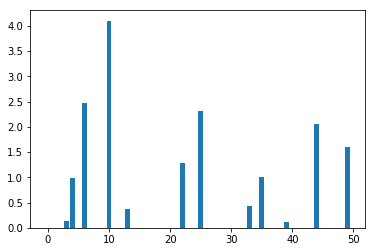

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor, BernoulliRBM
mean_error = []
train = raw[raw.index <= maxdat]
    
xtr = train.drop(['var1(t)'], axis=1)#, val.drop(['var1(t)'], axis=1)
ytr = train['var1(t)'].values#, val['var1(t)'].values
    
#mdl = RandomForestRegressor(n_estimators=10000, n_jobs=2, random_state=0)
#mdl = Ridge(alpha=100)
mdl = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01,loss='ls',max_depth=5)
#mdl = KNeighborsRegressor(n_neighbors=100)
#mdl = MLPRegressor(hidden_layer_sizes=(1, ),solver='lbfgs',alpha=.000001)
#mdl = BernoulliRBM()
mdl.fit(xtr, ytr)
changedict={}
for key in testing.keys():
    xts = testing[key].drop(['var1(t)'],axis=1)
    yts = testing[key]['var1(t)'].values
    gdp = stateinfo[(stateinfo['State']==key)]['2015'].values

    p0 = mdl.predict(xts)
#    print 'State: '+key#,xts,yts
    for rebate in range(10000,110000,30000):
        oldreb0 = xts['var2(t)']
        oldreb1 = xts['var2(t-1)']
        oldreb2 = xts['var2(t-2)']
    #    oldreb3 = xts['var2(t-3)']
    #    oldreb4 = xts['var2(t-4)']
    #    oldreb5 = xts['var2(t-5)']
        xts['var2(t)'] = oldreb0 + rebate*1./3/gdp
        xts['var2(t-1)'] = oldreb1 + rebate*1./3/gdp
        xts['var2(t-2)'] = oldreb2 + rebate*1./3/gdp
    #    xts['var2(t-3)'] = oldreb3 + rebate*1
    #    xts['var2(t-4)'] = oldreb4 + rebate*1
    #    xts['var2(t-5)'] = oldreb5 + rebate*1
    

        p = mdl.predict(xts)
    
        change  = p-p0
        changedict[key] = change/rebate*gdp
#        print('rebate %d - change %.5f' % (rebate, change))
print changedict
nstates = range(len(changedict.values()))
statelabels = changedict.keys(),
changes = [float(changedict[key]) for key in changedict.keys()]
pyplot.bar(nstates,changes,align='center')
#pyplot.xticks(nstates,statelabels)

[('AK', array([ 1.92807694])), ('AL', array([ 0.])), ('AR', array([ 0.])), ('AZ', array([ 0.])), ('CA', array([ 0.])), ('CO', array([ 0.])), ('CT', array([ 0.])), ('DE', array([ 0.])), ('FL', array([ 0.])), ('GA', array([ 0.])), ('HI', array([ 0.51524082])), ('IA', array([ 0.])), ('ID', array([ 0.21993067])), ('IL', array([ 0.])), ('IN', array([ 0.])), ('KS', array([ 0.])), ('KY', array([ 0.])), ('LA', array([ 0.])), ('MA', array([ 0.])), ('MD', array([ 0.])), ('ME', array([ 2.10431246])), ('MI', array([ 0.])), ('MN', array([ 0.])), ('MO', array([ 0.])), ('MS', array([ 0.02127989])), ('MT', array([ 1.02947206])), ('NC', array([ 0.])), ('ND', array([ 0.94894826])), ('NE', array([ 0.02326428])), ('NH', array([ 0.])), ('NJ', array([ 0.])), ('NM', array([ 0.])), ('NV', array([ 0.])), ('NY', array([ 0.])), ('OH', array([ 0.])), ('OK', array([ 0.])), ('OR', array([ 0.])), ('PA', array([ 0.])), ('RI', array([ 0.])), ('SC', array([ 0.])), ('SD', array([ 0.79675351])), ('TN', array([ 0.])), ('T

<BarContainer object of 50 artists>

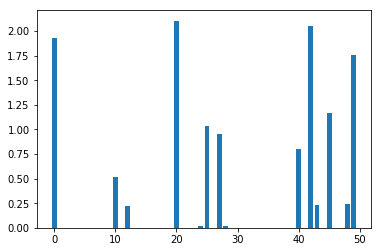

In [34]:
changedict={}
for key in testing.keys():
    xts = testing[key].drop(['var1(t)'],axis=1)
    yts = testing[key]['var1(t)'].values
    gdp = stateinfo[(stateinfo['State']==key)]['2015'].values[0]
#    print gdp
    p0 = mdl.predict(xts)
#    print 'State: '+key#,xts,yts
    for rebate in range(50000,250000,50000):
        oldreb0 = xts['var2(t)']
        oldreb1 = xts['var2(t-1)']
        oldreb2 = xts['var2(t-2)']
        oldreb3 = xts['var2(t-3)']
        oldreb4 = xts['var2(t-4)']
        oldreb5 = xts['var2(t-5)']
        xts['var2(t)'] = oldreb0 + rebate*1/6./gdp
        xts['var2(t-1)'] = oldreb1 + rebate*1/6./gdp
        xts['var2(t-2)'] = oldreb2 + rebate*1/6./gdp
        xts['var2(t-3)'] = oldreb3 + rebate*1/6./gdp
        xts['var2(t-4)'] = oldreb4 + rebate*1/6./gdp
        xts['var2(t-5)'] = oldreb5 + rebate*1/6./gdp
    

        p = mdl.predict(xts)
    
        change  = p-p0
        changedict[key] = change/rebate*gdp
#        print('rebate %d - change %.5f' % (rebate, change))
print sorted(changedict.items())
nstates = range(len(changedict.values()))
statelabels = changedict.keys(),
changes = [float(changedict[key]) for key in sorted(changedict.keys())]
pyplot.bar(nstates,changes,align='center')
#pyplot.xticks(nstates,statelabels)

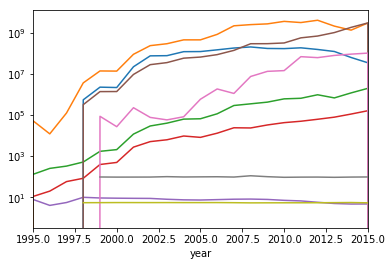

In [21]:
this_state = df['state'].value_counts().index[0]
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['rebates'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['cost'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['size_kw'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['count'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).mean()['cost_per_watt'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['annual_PV_prod'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).sum()['reported_annual_energy_prod'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).mean()['pct_reported_prod'].plot(logy=True,xlim=(1995,2015))
ax1=df[(df['state']==this_state)].groupby(['year']).mean()['annual_insolation'].plot(logy=True,xlim=(1995,2015))

In [126]:

mldf = df[['state','date','size_kw','new_insolation','cost','cost_per_watt','year','count','rebates','reported_annual_energy_prod','annual_PV_prod','tilt1','azimuth1','install_type']].copy()
mldftest = df[['state','date','size_kw','annual_insolation','cost','cost_per_watt','year','count','rebates','reported_annual_energy_prod','annual_PV_prod','tilt1','azimuth1','install_type']]

In [128]:
mldf.head()

,state,date,size_kw,new_insolation,cost,cost_per_watt,year,count,rebates,reported_annual_energy_prod,annual_PV_prod,tilt1,azimuth1,install_type
0,TX,2013-12-15,10.560,5.157692,30600.53,2.897777,2013.0,1.0,15000.0,13836.0,14999.831600,10.0,180.0,residential
1,TX,2014-07-15,12.720,5.085633,40000.00,3.144654,2014.0,1.0,15000.0,16419.0,17811.574390,7.0,180.0,residential
2,TX,2014-01-15,5.400,5.262714,22665.58,4.197330,2014.0,1.0,7735.5,7235.0,7833.742822,18.5,165.0,residential
3,IN,2017-10-15,6.785,4.560000,17550.00,2.590000,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,residential
4,IN,2017-10-15,4.720,4.560000,12150.00,2.570000,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,residential


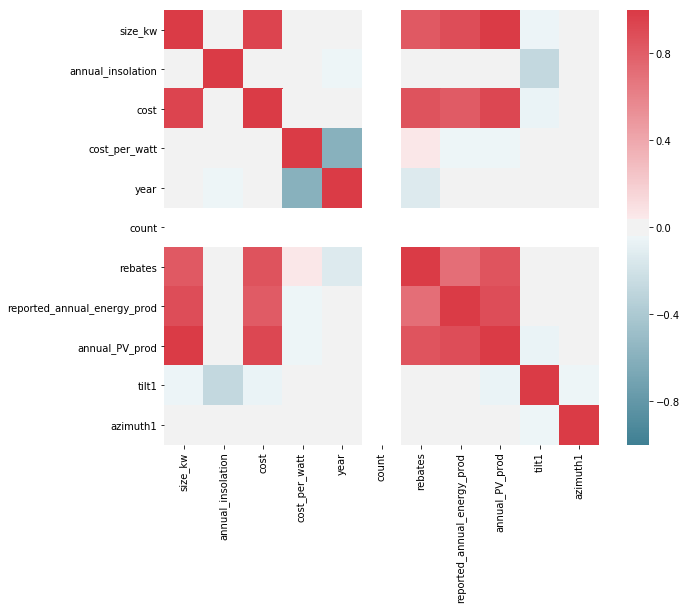

In [49]:
import seaborn as sns

f, ax = pyplot.subplots(figsize=(10, 8))
corr = mldftest.corr()
sns.heatmap(corr, mask=numpy.zeros_like(corr, dtype=numpy.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax,vmin=-1, vmax=1)

In [6]:
mldftest['rebates'] = df['rebates']*1.
mldftest['annual_insolation'] = df['annual_insolation']*1.

In [62]:
rep_energy_prod = mldftest[(mldftest['reported_annual_energy_prod']>0)&(df['install_type']=='residential')]['reported_annual_energy_prod']
ann_energy_prod = mldftest[(mldftest['reported_annual_energy_prod']>0)&(df['install_type']=='residential')]['annual_PV_prod']
ann_insol = mldf[(mldf['reported_annual_energy_prod']>0)&(df['install_type']=='residential')]['annual_insolation']
size = mldf[(mldf['reported_annual_energy_prod']>0)&(df['install_type']=='residential')]['size_kw']
energy_prod_ratio = 1/(rep_energy_prod/ann_insol/size)
energy_prod_ratio.replace(numpy.inf, 1.)
energy_prod_ratio.fillna(1.)
energy_prod_ratio.isnull().sum().sum()
energy_prod_ratio.mean()
pyplot.scatter(df['reported_annual_energy_prod']/df['annual_PV_prod'],df['tilt1'])
pyplot.xlim(.5,2)
#pyplot.ylim(0,360)

KeyError: 'annual_insolation'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000015E88BE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000164701D0>]], dtype=object)

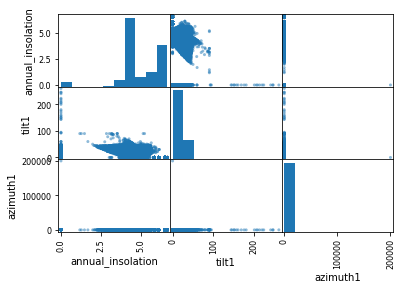

In [40]:
train = mldf[(mldf['reported_annual_energy_prod']>0)&(mldf['install_type']=='residential')].loc[:,['annual_insolation','tilt1','azimuth1']]
test = mldftest[(mldftest['install_type']=='residential')].loc[:,['annual_insolation','tilt1','azimuth1']]

energy_prod_ratio.reset_index()
train.reset_index()
train.isnull().sum().sum()
pandas.plotting.scatter_matrix(df[])

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

mlpipe = Pipeline([
#        ('dvect',DictVectorizer()),
#        ('linreg',LinearRegression()),
#        ('ridge',Ridge(alpha=0.1)),
        ('rfr',RandomForestRegressor()),
#        ('knr',KNeighborsRegressor(n_neighbors=3))
#        ('resreg',ResidualEstimator(Ridge(alpha = 5000.0),KNeighborsRegressor(n_neighbors=6))),
    ])

#mlpipe.fit(train,rep_energy_prod)
mlpipe.fit(train,energy_prod_ratio)

Pipeline(memory=None,
     steps=[('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [80]:
pred1 = mlpipe.predict(test)

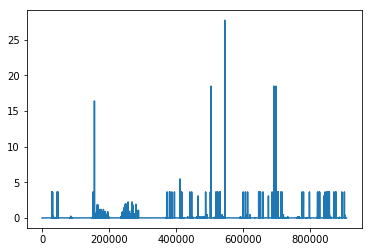

In [81]:
pyplot.plot(pred1)

In [8]:
rep_energy_prod.shape

(187336L,)

In [34]:
train = mldf[(mldf['reported_annual_energy_prod']>0)&(mldf['install_type']=='residential')].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]
test = mldftest[(mldftest['reported_annual_energy_prod']<=0)].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]
test2 = mldf[(mldf['reported_annual_energy_prod']<=0)].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]


In [35]:
mldftest['rebates'] = mldf['rebates']*5
mldftest['annual_insolation'] = mldf['annual_insolation']*1.
train = mldf[(mldf['reported_annual_energy_prod']>0)&(mldf['install_type']=='residential')].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]
test = mldftest[(mldftest['install_type']=='residential')].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]
test2 = mldf[(mldf['install_type']=='residential')].loc[:,['size_kw','annual_insolation','cost','year','rebates','tilt1','azimuth1']]


In [36]:
train.shape
test.shape

(908085, 7)

In [37]:
from sklearn import base
class ResidualEstimator(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, est1, est2):
        self.est1 = est1
        self.est2 = est2
        self.y = None
        self.residuals = []
        self.fit1s = None
        
    def fit(self, X, y=None):
        self.y = y
        self.est1.fit(X,y)
        self.residuals = self.y-self.est1.predict(X)
        self.est2.fit(X,self.residuals)      
        return self
    
    def predict(self, X):
        prediction = self.est2.predict(X)+self.est1.predict(X)
        return prediction


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

mlpipe = Pipeline([
#        ('dvect',DictVectorizer()),
#        ('linreg',LinearRegression()),
#        ('ridge',Ridge(alpha=0.1)),
        ('rfr',RandomForestRegressor()),
#        ('knr',KNeighborsRegressor(n_neighbors=3))
#        ('resreg',ResidualEstimator(Ridge(alpha = 5000.0),KNeighborsRegressor(n_neighbors=6))),
    ])

mlpipe.fit(train,rep_energy_prod)
#mlpipe.fit(train,energy_prod_ratio)

Pipeline(memory=None,
     steps=[('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [72]:
normal = mlpipe.predict(test2)
modified = mlpipe.predict(test)

-0.00350760607221


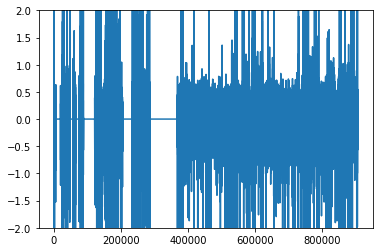

In [73]:
pyplot.plot((normal-modified)/normal)
pyplot.ylim(-2,2)
print numpy.mean((normal-modified)/normal)

In [69]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(mlpipe,{'resreg__est1__alpha':range(500,5500,500),'resreg__est2__n_neighbors':range(5,8,1)},scoring='r2')
#gs = GridSearchCV(mlpipe,{'knr__n_neighbors':range(1,11,1)},scoring='r2')
gs.fit(train,rep_energy_prod)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('resreg', ResidualEstimator(est1=Ridge(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         est2=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=6, p=2,
          weights='uniform')))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'resreg__est1__alpha': [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000], 'resreg__est2__n_neighbors': [5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [70]:
print gs.best_params_
#print gs.cv_results_

{'resreg__est1__alpha': 5000, 'resreg__est2__n_neighbors': 6}


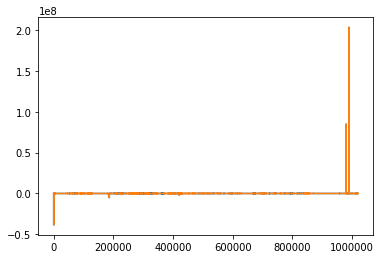

In [75]:
pyplot.plot(mldftest[(mldftest['install_type']=='residential')]['annual_PV_prod']-normal)
pyplot.plot(mldftest[(mldftest['install_type']=='residential')]['annual_PV_prod']-modified)